# Model Training

This file will train the model and evaluate it's performance and then save the model for use in production.

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy

In [2]:
# Define the data files
interaction_data_file = 'data/interaction_data_prepared.csv'

# Import data file into dataframe
interaction_dataframe = pd.read_csv(interaction_data_file)

In [3]:
# Prepare data for Surprise using the weighted interactions
reader = Reader(rating_scale=(interaction_dataframe['SCORE'].min(), interaction_dataframe['SCORE'].max()))
data = Dataset.load_from_df(interaction_dataframe[['USER_ID', 'BRAND_ID', 'SCORE']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.25)

# Define the best KNN model parameters
best_svd_params = {
    'n_factors': 50,
    'n_epochs': 300,
    'lr_all': 0.005,
    'reg_all': 0.02
}

# Initialize the KNN model with the best parameters
best_svd = SVD(n_factors=best_svd_params['n_factors'], n_epochs=best_svd_params['n_epochs'], lr_all=best_svd_params['lr_all'], reg_all=best_svd_params['reg_all'])

# Train the model on the training set
best_svd.fit(trainset)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1862  0.1841  0.1860  0.1849  0.1848  0.1852  0.0008  
MAE (testset)     0.1480  0.1458  0.1467  0.1463  0.1461  0.1466  0.0007  
Fit time          6.38    6.10    6.16    6.15    6.21    6.20    0.10    
Test time         0.13    0.06    0.12    0.06    0.06    0.09    0.03    
RMSE: 0.1569
MAE:  0.1225

Cross-validation results:
Mean RMSE: 0.18521032086331915
Mean MAE: 0.14659784161287076

Test set results:
Test RMSE: 0.15688816518128168
Test MAE: 0.12249967836369487


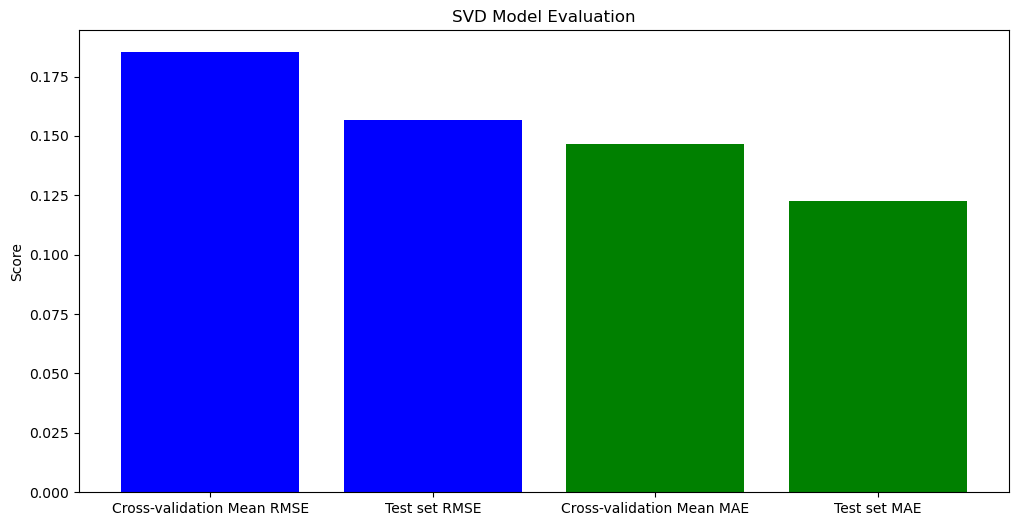

In [4]:
# Perform cross-validation and get results
cv_results = cross_validate(best_svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Test the model on the test set
test_predictions = best_svd.test(testset)

# Compute test set RMSE and MAE
test_rmse = accuracy.rmse(test_predictions, verbose=True)
test_mae = accuracy.mae(test_predictions, verbose=True)

# Cross-validation results
mean_rmse_cv = cv_results['test_rmse'].mean()
mean_mae_cv = cv_results['test_mae'].mean()

# Print the results
print("\nCross-validation results:")
print(f"Mean RMSE: {mean_rmse_cv}")
print(f"Mean MAE: {mean_mae_cv}")

print(f"\nTest set results:")
print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")

# Prepare data for visualization
metrics = ['Cross-validation Mean RMSE', 'Test set RMSE', 'Cross-validation Mean MAE', 'Test set MAE']
scores = [mean_rmse_cv, test_rmse, mean_mae_cv, test_mae]

# Bar plot for RMSE and MAE comparison
plt.figure(figsize=(12, 6))
plt.bar(metrics, scores, color=['blue', 'blue', 'green', 'green'])
plt.title('SVD Model Evaluation')
plt.ylabel('Score')
plt.grid(False)
plt.show()

In [5]:
# Save the trained model to a file
with open('model/svd_brand_recommendation_model.pkl', 'wb') as model_file:
    pickle.dump(best_svd, model_file)